# TP3 : Clustering

## Imports et configuration

In [1]:
# Imports

import collections
import os
import re
import string
import sys
from collections import Counter
from pprint import pprint

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import yake
from nltk import word_tokenize
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from IPython.display import Image
from IPython.display import display
nltk.download('stopwords')

import pandas as pd
from nltk.corpus import stopwords
from scipy.spatial.distance import cosine
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer

# Config

txt_path = '../data/txt/'

temp_path = '../data/tmp/'
if not os.path.exists(temp_path):
    os.mkdir(temp_path)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\glmqu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\glmqu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Charger tous les  fichiers de la décennie et en créer une liste de textes

In [2]:
DECADE = '1930'

files = [f for f in sorted(os.listdir(txt_path)) if f"_{DECADE[:-1]}" in f]

# Vérifier si c'est bien 1930: OK
print(files[:5])

texts = [open(txt_path + f, "r", encoding="utf-8").read() for f in files]

# Pour voir à quoi ressemble le premier document: tout est OK
print(texts[0][:400])

['KB_JB838_1930-01-05_01-00006.txt', 'KB_JB838_1930-01-09_01-00001.txt', 'KB_JB838_1930-01-09_01-00014.txt', 'KB_JB838_1930-01-16_01-00010.txt', 'KB_JB838_1930-01-20_01-00002.txt']
15 G I C 3. L ^ SQ| R V .1- . FINANCE - INDUSTRIE - COMMERCE BOURSE de BRUXELLES I Marchés d’Anvers REVUE HEBDOMADAIRE La Eourse, qui avait très peu de chance de g.tg:v»r en aciivi.é penciant cette semaine raccourcie par le congé du Nouvel- Aii, a c i cependant une attitude qui permet de bien augurer des prochaines séances. L's capitalistes semblent enfin s’être rendu compte cours leur fou: quelqu


## Vectoriser les documents à l'aide de TF-IDF

In [3]:
# Création d'une fonction de pré-traitement

def preprocessing(text, stem=True):
    """ Tokenize text and remove punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
    return tokens

# Instancier le modèle TF-IDF avec ses arguments

vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    max_df=0.5, #ignorer les mots apparaissant dans plus de 50% des docs
    min_df=0.1, #ignorer les mots apparaissant dans moins de 10% des docs
    lowercase=True #tout mettre en minuscules
)

# Construire la matrice de vecteurs à l'aide de la fonction `fit_transform`

tfidf_vectors = vectorizer.fit_transform(texts)

In [4]:
# Imprimer les détails de la matrice

tfidf_vectors

<1000x3941 sparse matrix of type '<class 'numpy.float64'>'
	with 789289 stored elements in Compressed Sparse Row format>

## Appliquer un algorithme de clustering sur les vecteurs TF-IDF des documents

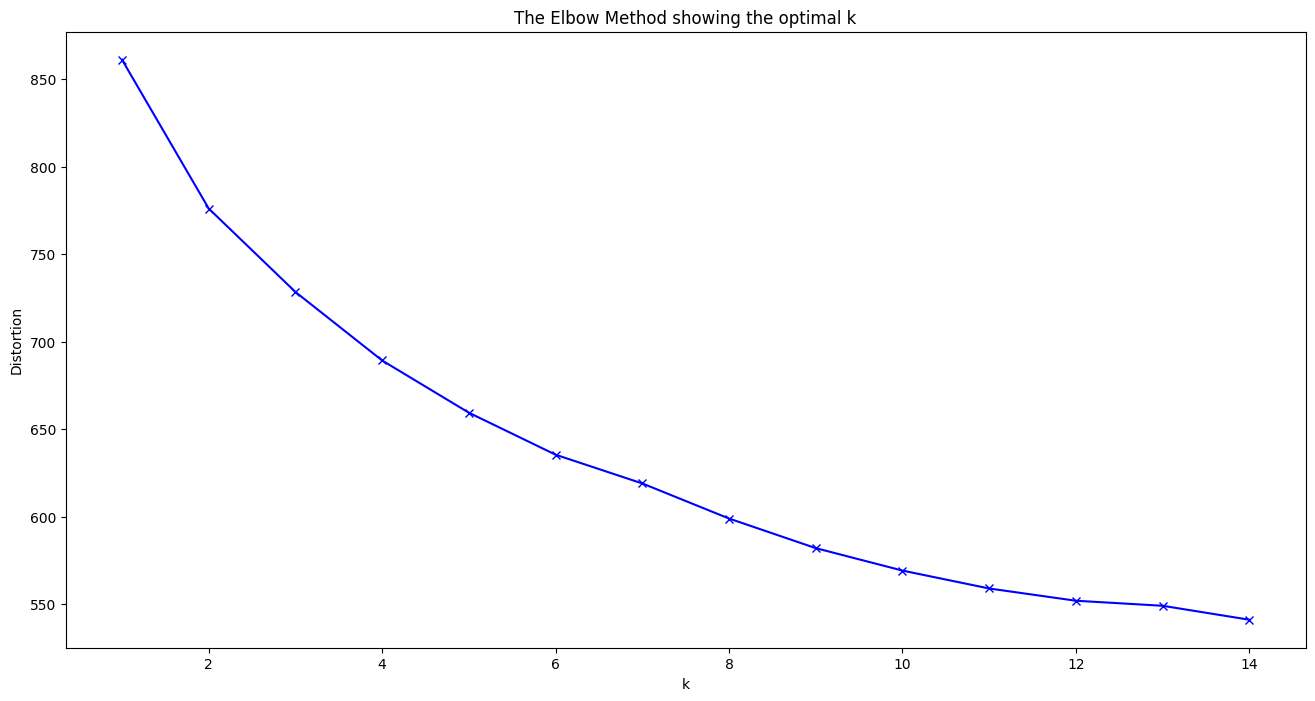

In [27]:
# Elbow method, disabled

distortions = []
K = range(1,15) #tested:1-10, 1-15, 1-30
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(tfidf_vectors)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [6]:
# Nbre clusters

N_CLUSTERS = 4

# Instancier le modèle K-Means et ses arguments

km_model = KMeans(n_clusters=N_CLUSTERS)

# Appliquer le clustering à l'aide de la fonction fit_predict

clusters = km_model.fit_predict(tfidf_vectors)

clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(files[idx])

In [7]:
# Afficher le résultat du clustering (un dictionnaire)

dict(clustering)

{1: ['KB_JB838_1930-01-05_01-00006.txt',
  'KB_JB838_1930-01-09_01-00001.txt',
  'KB_JB838_1930-01-20_01-00002.txt',
  'KB_JB838_1930-01-30_01-00006.txt',
  'KB_JB838_1930-02-05_01-00005.txt',
  'KB_JB838_1930-03-01_01-00004.txt',
  'KB_JB838_1930-03-13_01-00003.txt',
  'KB_JB838_1930-03-21_01-00004.txt',
  'KB_JB838_1930-04-03_01-00004.txt',
  'KB_JB838_1930-04-06_01-00007.txt',
  'KB_JB838_1930-04-07_01-00003.txt',
  'KB_JB838_1930-04-14_01-00006.txt',
  'KB_JB838_1930-04-16_01-00016.txt',
  'KB_JB838_1930-05-06_01-00008.txt',
  'KB_JB838_1930-05-18_01-00011.txt',
  'KB_JB838_1930-06-16_01-00004.txt',
  'KB_JB838_1930-06-24_01-00004.txt',
  'KB_JB838_1930-07-25_01-00005.txt',
  'KB_JB838_1930-07-26_01-00006.txt',
  'KB_JB838_1930-08-05_01-00004.txt',
  'KB_JB838_1930-08-11_01-00003.txt',
  'KB_JB838_1930-08-17_01-00004.txt',
  'KB_JB838_1930-08-19_01-00003.txt',
  'KB_JB838_1930-08-20_01-00002.txt',
  'KB_JB838_1930-08-21_01-00005.txt',
  'KB_JB838_1930-08-29_01-00001.txt',
  'KB_JB8

## Visualiser les clusters

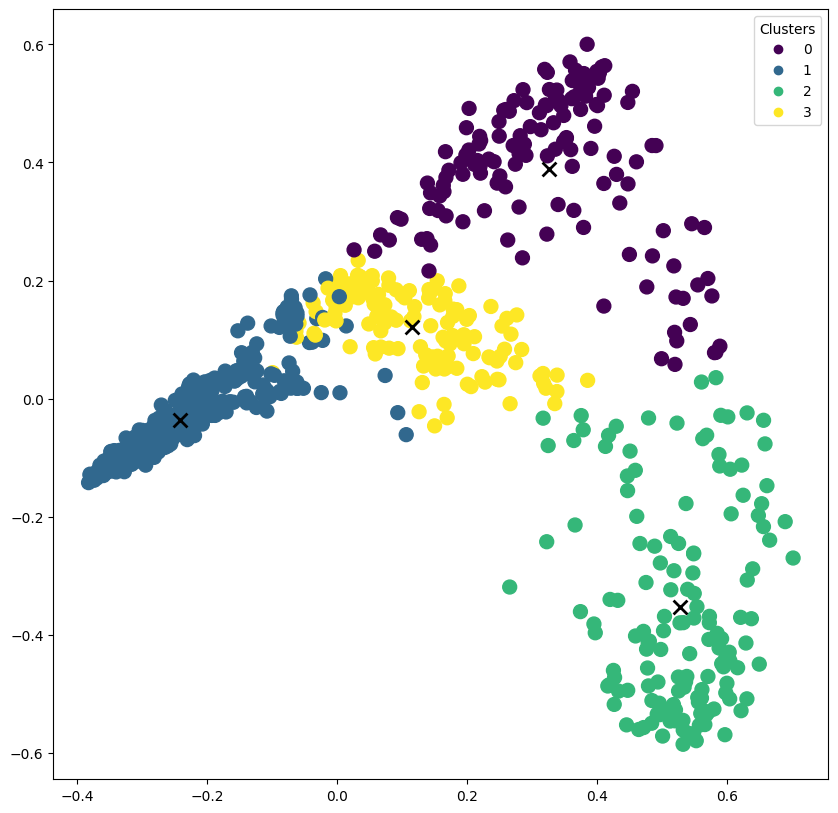

In [8]:
# Réduire les vecteurs à 2 dimensions

pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors.toarray())

# Générer le graphe

x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

## Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

## Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")

## Explorer les clusters

In [9]:
# Créer des fichiers tmp avec les textes des clusters

for key in clustering.keys():
    
    tmp_content_list = []

    for txt in clustering[key]:
        
        with open(os.path.join(txt_path, txt), 'r', encoding="utf-8") as f:
            tmp_content_list.append(f.read())
        
    with open(os.path.join(temp_path, f'{DECADE}s_cluster_{key}.txt'), 'w', encoding="utf-8") as f:
        f.write(' '.join(tmp_content_list))   

### Autour des fichiers

In [11]:
# Regarder le nombre de documents par cluster. Y en a-t-il un qui "regroupe" la majorité des documents ?

for key in clustering.keys():
    print(f"Nombre de documents dans le cluster {key} : {len(clustering[key])}")

Nombre de documents dans le cluster 1 : 574
Nombre de documents dans le cluster 3 : 140
Nombre de documents dans le cluster 2 : 145
Nombre de documents dans le cluster 0 : 141


Cluster n° 1, Nbre doc : 574, Counter({'1937': 67, '1939': 65, '1935': 64, '1934': 60, '1936': 60, '1938': 59, '1933': 58, '1932': 53, '1931': 46, '1930': 42})


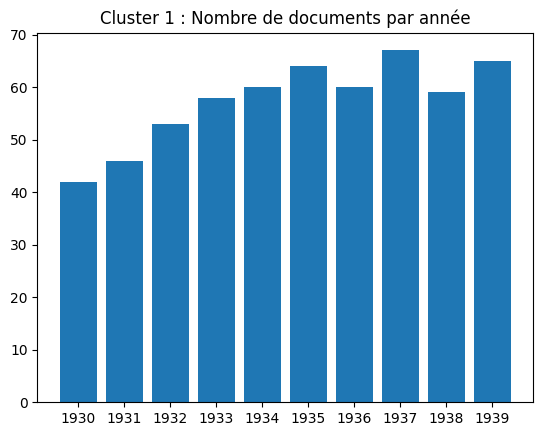

Cluster n° 3, Nbre doc : 140, Counter({'1930': 24, '1932': 18, '1931': 17, '1934': 14, '1933': 13, '1939': 13, '1937': 12, '1936': 11, '1935': 10, '1938': 8})


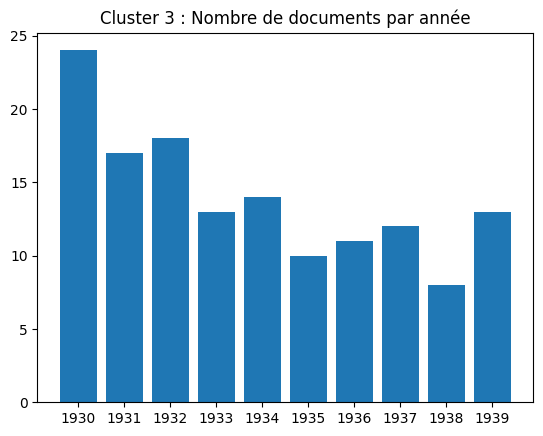

Cluster n° 2, Nbre doc : 145, Counter({'1930': 21, '1936': 21, '1938': 19, '1931': 17, '1934': 16, '1939': 13, '1935': 12, '1932': 10, '1933': 8, '1937': 8})


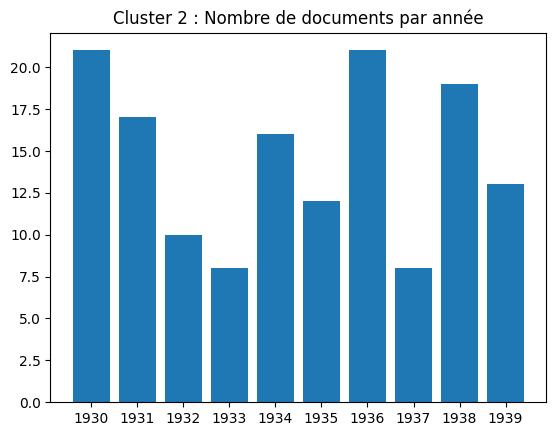

Cluster n° 0, Nbre doc : 141, Counter({'1933': 21, '1931': 20, '1932': 19, '1935': 14, '1938': 14, '1930': 13, '1937': 13, '1934': 10, '1939': 9, '1936': 8})


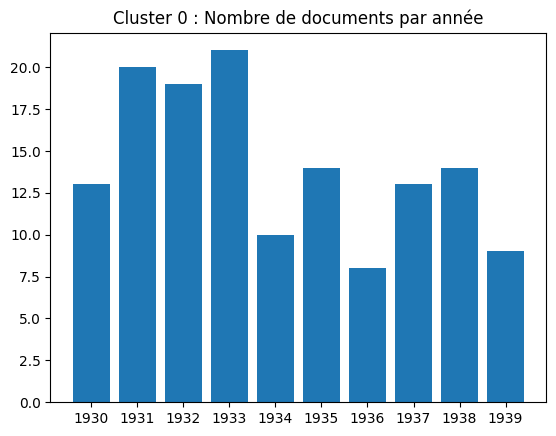

In [12]:
# Regarder si la distribution des clusters est différente selon les années (via un graphique)

def get_year(filename): #renvoie l'année détectée
    year = (re.search("([0-9]{4})", filename)).group()
    return year

years_per_cluster = []
for key in clustering.keys():
    years_per_cluster.append([])

for key in clustering.keys():
    for i in clustering[key]:
        years_per_cluster[key].append(get_year(i))
    
    # print(key, len(years_per_cluster[key]))

# print(years_per_cluster[0].count('1932'))

for key in clustering.keys():
    tmp_counter = Counter(years_per_cluster[key])
    print(f"Cluster n° {key},", f"Nbre doc : {len(clustering[key])},", tmp_counter)

    plt.bar(tmp_counter.keys(), tmp_counter.values())
    plt.title(f"Cluster {key} : Nombre de documents par année")
    plt.show()

### Keywords

In [13]:
# Regarder les mots-clés de chaque cluster et voir s'il y a des éléments intéressants qui en ressortent (pourquoi pas leur attribuer un "thème")

# Instantier l'extracteur de mots clés en fr + les 50 premiers
kw_extractor = yake.KeywordExtractor(lan="fr", top=50)
kw_extractor

# Récupérer le texte sauvegardé ci-dessus
text = open(os.path.join(temp_path, f'{DECADE}s_cluster_0.txt'), 'r', encoding="utf-8").read()

# Extraire les mots clés de ce texte
keywords = kw_extractor.extract_keywords(text)
keywords

# Ne garder que les bigrammes / trigrammes
kept_bigrams = []
kept_trigrams = []
for kw, score in keywords:
    words = kw.split()
    if len(words) == 2:
        kept_bigrams.append(kw)
    elif len(words) == 3:
        kept_trigrams.append(kw)

print(f"Bigrammes récurrents, cluster n° 0 : {kept_bigrams}")
print(f"Trigrammes récurrents, cluster n° 0 : {kept_trigrams}")
print("")

Bigrammes récurrents, cluster n° 0 : ['Agence RosseL', 'LOUER MAISON', 'LOUER bel', 'Belle maison', 'bel app', 'LOUER App', 'louer belle', 'louer rue', 'rue Royale', 'louer Villa']
Trigrammes récurrents, cluster n° 0 : ['LOUER belle maison', 'Ecrire Agence ROSSEL', 'vendre belle maison', 'LOUER bel app', 'louer rue Royale', 'LOUER bel appart', 'LOUER BEL APPARTEMENT', 'louer petite maison', 'louer jolie maison', 'vendre Jolie maison', 'Agence Rossel Bruxelles', 'louer belle villa', 'LOUER bel Immeuble', 'LOUER BEAUX APPARTEMENTS', 'rue Agence Rossel', 'LOUER Agence Rossel', 'louer bel appartem', 'prix Agence Rossel', 'louer Maison Moderne', 'CHERCHE louer maison', 'belle maison moderne', 'LOUER Appartement moderne', 'DESIRE louer maison', 'louer grande maison', 'LOUER MAISON porte', 'Ler bel app', 'LOUER bonne maison', 'LOUER beau magasin', 'louer maison bel', 'LOUER MAISON Jard.', 'vendre belle villa', 'LOUER belles maisons', 'LOUER MIDI Maison', 'LOUER bel ATELIER', 'LOUER MAISON qua

In [14]:
# Regarder les mots-clés de chaque cluster et voir s'il y a des éléments intéressants qui en ressortent (pourquoi pas leur attribuer un "thème")

# Instantier l'extracteur de mots clés en fr + les 50 premiers
kw_extractor = yake.KeywordExtractor(lan="fr", top=50)
kw_extractor

# Récupérer le texte sauvegardé ci-dessus
text = open(os.path.join(temp_path, f'{DECADE}s_cluster_1.txt'), 'r', encoding="utf-8").read()

# Extraire les mots clés de ce texte
keywords = kw_extractor.extract_keywords(text)
keywords

# Ne garder que les bigrammes / trigrammes
kept_bigrams = []
kept_trigrams = []
for kw, score in keywords:
    words = kw.split()
    if len(words) == 2:
        kept_bigrams.append(kw)
    elif len(words) == 3:
        kept_trigrams.append(kw)

print(f"Bigrammes récurrents, cluster n° 1 : {kept_bigrams}")
print(f"Trigrammes récurrents, cluster n° 1 : {kept_trigrams}")
print("")

Bigrammes récurrents, cluster n° 1 : ['Bruxelles Bruxelles', 'Dernier cours', 'Paris Paris', 'Congo Belge', 'Mme Van', 'rue Van', 'Londres Londres']
Trigrammes récurrents, cluster n° 1 : ['BRUXELLES BRUXELLES BRUXELLES', 'Janvier Mars Mai', 'BRUXELLES NAMUR BRUXELLES', 'Mai Juin Juillet', 'Mars Mai Juillet', 'Cie Congo Belge', 'Mai Juillet Octobre', 'BRUXELLES BONNE MAISON', 'Liège BRUXELLES Anver', 'Union Nautique Bruxelles', 'Juin Juillet Août', 'PAUL VAN ZEELAND', 'Janvier Février Mars', 'ANVERS ANVERS ANVERS', 'Sport Nautique Bruxelles', 'Décembre Janvier Mars', 'Mars Avril Mai', 'Novembre Décembre Janvier', 'Avril Mai juin', 'ledit notaire VAN', 'rue Jules Van', 'Juillet Août Septembre', 'FOREST BRUXELLES BRUXELLES', 'Octobre Novembre Janvier', 'Fédération royale belge', 'Société royale Sport', 'BRUXELLES BRUXELLES HALLE', 'Mme Jean VAN', 'Février Mars Avril', 'Octobre Décembre Janvier', 'bat Mme Van', 'Septembre Octobre Novembre', 'Bruxelles lundi soir', 'Londres Paris Italie', '

In [15]:
# Regarder les mots-clés de chaque cluster et voir s'il y a des éléments intéressants qui en ressortent (pourquoi pas leur attribuer un "thème")

# Instantier l'extracteur de mots clés en fr + les 50 premiers
kw_extractor = yake.KeywordExtractor(lan="fr", top=50)
kw_extractor

# Récupérer le texte sauvegardé ci-dessus
text = open(os.path.join(temp_path, f'{DECADE}s_cluster_2.txt'), 'r', encoding="utf-8").read()

# Extraire les mots clés de ce texte
keywords = kw_extractor.extract_keywords(text)
keywords

# Ne garder que les bigrammes / trigrammes
kept_bigrams = []
kept_trigrams = []
for kw, score in keywords:
    words = kw.split()
    if len(words) == 2:
        kept_bigrams.append(kw)
    elif len(words) == 3:
        kept_trigrams.append(kw)

print(f"Bigrammes récurrents, cluster n° 2 : {kept_bigrams}")
print(f"Trigrammes récurrents, cluster n° 2 : {kept_trigrams}")
print("")

Bigrammes récurrents, cluster n° 2 : ['Agence Rossel', 'Ecrire Agence', 'JNE fille', 'Jeune fille', 'Dames dem', 'cherche place']
Trigrammes récurrents, cluster n° 2 : ['Ecrire Agence Rossel', 'Agence Rossel Bruxelles', 'Offre AGENCE ROSSEL', 'DEMANDE Jeune fille', 'JNE FILLE dem', 'Ecr Agence Rossel', 'rue Agence Rossel', 'références Agence ROSSEL', 'JEUNE fille dem', 'DEMANDE Agence Rossel', 'prix Agence Rossel', 'JNE FEMME dem', 'demande bon ouvrier', 'DEMANDE Jeune homme', 'DAME seule dem', 'JEUNE DAME DEM', 'COIFFEUR dames dem', 'cherche Agence Rossel', 'DEM Jeune fille', 'DEMANDE bonne servante', 'BRUXELLES ECRIRE AGENCE', 'adresse Agence Rossel', 'prétentions Agence Rossel', 'JEUNE FILLE demande', 'conditions Agence Rossel', 'Bruxelles DEMANDE Bonne', 'JNE FEM. dem', 'JEUNE femme dem', 'RUE NEUVE demande', 'Agence Rossel numéro', 'JNE DAME dem', 'rue Jules Van', 'demande BON REPRESENTANT', 'Bon Représentant dem', 'COUTURE Agence Rossel', 'FIRME IMPORTANTE dem', 'DEM Jne fille', 

In [16]:
# Regarder les mots-clés de chaque cluster et voir s'il y a des éléments intéressants qui en ressortent (pourquoi pas leur attribuer un "thème")

# Instantier l'extracteur de mots clés en fr + les 50 premiers
kw_extractor = yake.KeywordExtractor(lan="fr", top=50)
kw_extractor

# Récupérer le texte sauvegardé ci-dessus
text = open(os.path.join(temp_path, f'{DECADE}s_cluster_3.txt'), 'r', encoding="utf-8").read()

# Extraire les mots clés de ce texte
keywords = kw_extractor.extract_keywords(text)
keywords

# Ne garder que les bigrammes / trigrammes
kept_bigrams = []
kept_trigrams = []
for kw, score in keywords:
    words = kw.split()
    if len(words) == 2:
        kept_bigrams.append(kw)
    elif len(words) == 3:
        kept_trigrams.append(kw)

print(f"Bigrammes récurrents, cluster n° 3 : {kept_bigrams}")
print(f"Trigrammes récurrents, cluster n° 3 : {kept_trigrams}")
print("")

Bigrammes récurrents, cluster n° 3 : ['Agence Rossel', 'bas prix', 'bon état', 'rue Royale', 'Rue Van', 'BRUXELLES Tél', 'Ecrire Agence', 'haut prix', 'Bon piano', 'ACHAT Bons']
Trigrammes récurrents, cluster n° 3 : ['Ecrire Agence Rossel', 'AGENCE CITROEN Rue', 'vendre bas prix', 'ACHAT Bons vieux', 'prix Agence Rossel', 'Ouvrier vend prix', 'ACHAT Haut prix', 'HAUT PRIX Bijoux', 'occasions BAS PRIX', 'Rossel Agence Rossel', 'rue Jules Van', 'Agence Rossel Agence', 'BRUXELLES BAS PRIX', 'BAS PRIX Tél', 'rue Van Artevelde', 'FORD FORD FORD', 'GRAND CHOIX PIANOS', 'Cherche piano Occasion', 'BAS PRIX CREDIT', 'état vendre prix', 'vend prix revient', 'rue Gaucheret BRUXELLES', 'bas prix PIANO', 'PIANOS bas prix', 'Agence RENAULT Tél', 'CITROEN Rue Gray', 'BRUXELLES demandez prix', 'Agence bon prix', 'BAS PRIX Vend', 'vend Bas prix']



### Nuage de mots

In [24]:
# Stopwords
sw = stopwords.words("french")
sw += [
    # Coquilles OCR pas enlevées par fonction de nettoyage
    "brux", "belg", "cond", "intér","télép", "téléph", "parf", "aven", "épous", "lntér", "poli", "référ", "culs", "serv", "trav", "pers", "conf", "sach", "conn", "cuis", "chauf", "chauff", "journ", "cherc", "flam", "exlg", "ouvr", "prop", "meub", "domest", "chaus", "préf", "angl", "inst", "repr", "jard", "chamb", "terr", "franç", "élect", "conv", "rapp", "centr", "atel", "plac", "appartem", "coch", "tranq", "pled", "compr", "schaerb", "condlt", "adres", "aujourd", "couch", "compt", "pens", "exig", "conc", "comp", "situât", "merc", "gara", "couch", "charlerol",
    # Mots (quasiment) vides de sens
    "les", "plus", "cette", "fait", "faire", "être", "deux", "comme", "dont", "tout", "ils", "bien", "sans", "peut", "tous", "après", "ainsi", "donc", "cet", "sous", "celle", "entre", "encore", "toutes", "toute", "pendant", "moins", "dire", "voir", "cela", "non", "faut", "trois", "quatre", "cinq", "quart", "demi", "aussi", "dit", "avoir", "doit", "contre", "depuis", "autres", "van", "het", "autre", "jusqu", "très", "trop", "chez", "près", "toutes", "leurs", "avant", "suite", "rien", "quelques", "puis", "alors", "quand", "ceux", "elles", "déjà", "celui", "devant", "toujours", "outre", "tant", "mieux", "assez", "beaucoup", "plusieurs", "quelque", "quelques", "vers", "ensuite", "voici", "notamment", "chaque", "laquelle", "parmi",
    # Mots pas pertinents dans le contexte du journal
    "rossel", "agence", "nord", "midi", "royale", "ville", "avenue", "place", "boulevard", "chaussée", "saint", "octobre", "mardi", "août", "dimanche", "septembre", "lundi", "décembre", "janvier", "juin", "avril", "mercredi", "samedi", "novembre", "jeudi", "vendredi"]
sw = set(sw)

# Fonction de nettoyage

def clean_text(key, folder=None):
    if folder is None:
        input_path = f"{DECADE}s_cluster_{key}.txt"
        output_path = f"{DECADE}s_cluster_{key}_clean.txt"
    else:
        input_path = f"{folder}{DECADE}s_cluster_{key}.txt"
        output_path = f"{folder}{DECADE}s_cluster_{key}_clean.txt"
    output = open(output_path, "w", encoding='utf-8')
    with open(input_path, encoding='utf-8') as f:
        text = f.read()
        words = nltk.wordpunct_tokenize(text)
        kept = [w.lower() for w in words if len(w) > 3 and w.isalpha() and w.lower() not in sw]
        kept_string = " ".join(kept)
        output.write(kept_string)
    return f'Output has been written in {output_path}!'

In [25]:
# Appliquer la fonction et vérifier les résultats

for key in clustering.keys():

    clean_text(key, folder=temp_path)

    with open(os.path.join(temp_path, f'{DECADE}s_cluster_{key}_clean.txt'), 'r', encoding="utf-8") as f:
        after = f.read()

    # print(after[:500], "\n---")

    # Calculer les mots les plus fréquents et afficher les résultats

    frequencies = Counter(after.split())

    print(f"Cluster n° {key}", frequencies.most_common(200))
    print("")

    cloud = WordCloud(width=2000, height=1000, background_color='white').generate_from_frequencies(frequencies)
    cloud.to_file(os.path.join(temp_path, f"{DECADE}s_cluster_{key}.png"))

Cluster n° 1 [('bruxelles', 7214), ('prix', 4785), ('heures', 4191), ('cours', 3728), ('francs', 3728), ('paris', 3432), ('grand', 3234), ('belgique', 3040), ('anvers', 3001), ('pays', 2943), ('gouvernement', 2940), ('belge', 2804), ('lieu', 2755), ('soir', 2723), ('ministre', 2673), ('maison', 2583), ('concert', 2565), ('président', 2483), ('part', 2430), ('grande', 2426), ('france', 2420), ('disques', 2410), ('londres', 2375), ('général', 2302), ('dernier', 2274), ('jour', 2269), ('mars', 2264), ('mois', 2245), ('mètres', 2221), ('premier', 2194), ('temps', 2174), ('notaire', 2045), ('juillet', 1972), ('orchestre', 1922), ('points', 1875), ('première', 1865), ('série', 1841), ('matin', 1832), ('conseil', 1803), ('musique', 1765), ('allemagne', 1760), ('guerre', 1756), ('jours', 1752), ('union', 1749), ('français', 1683), ('jean', 1679), ('politique', 1677), ('chambre', 1671), ('congo', 1664), ('société', 1650), ('liège', 1624), ('partie', 1620), ('heure', 1599), ('ordre', 1560), ('et

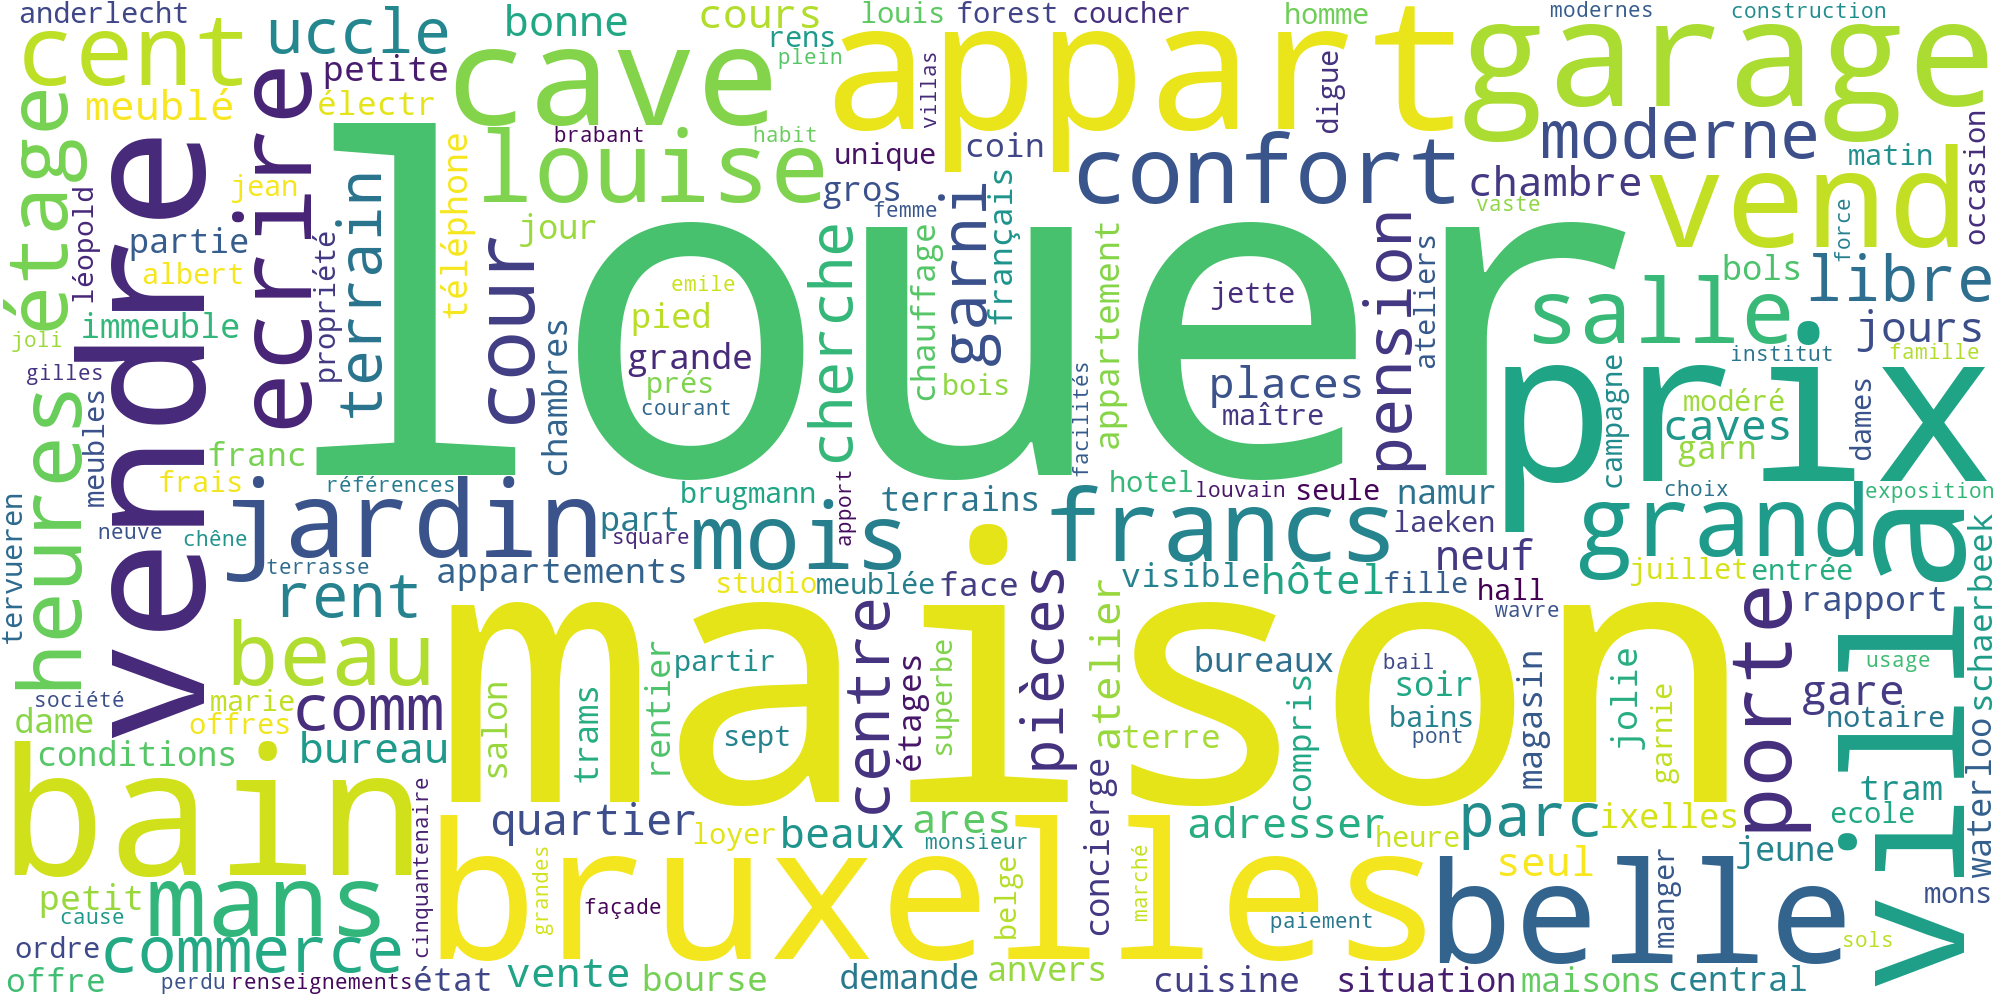

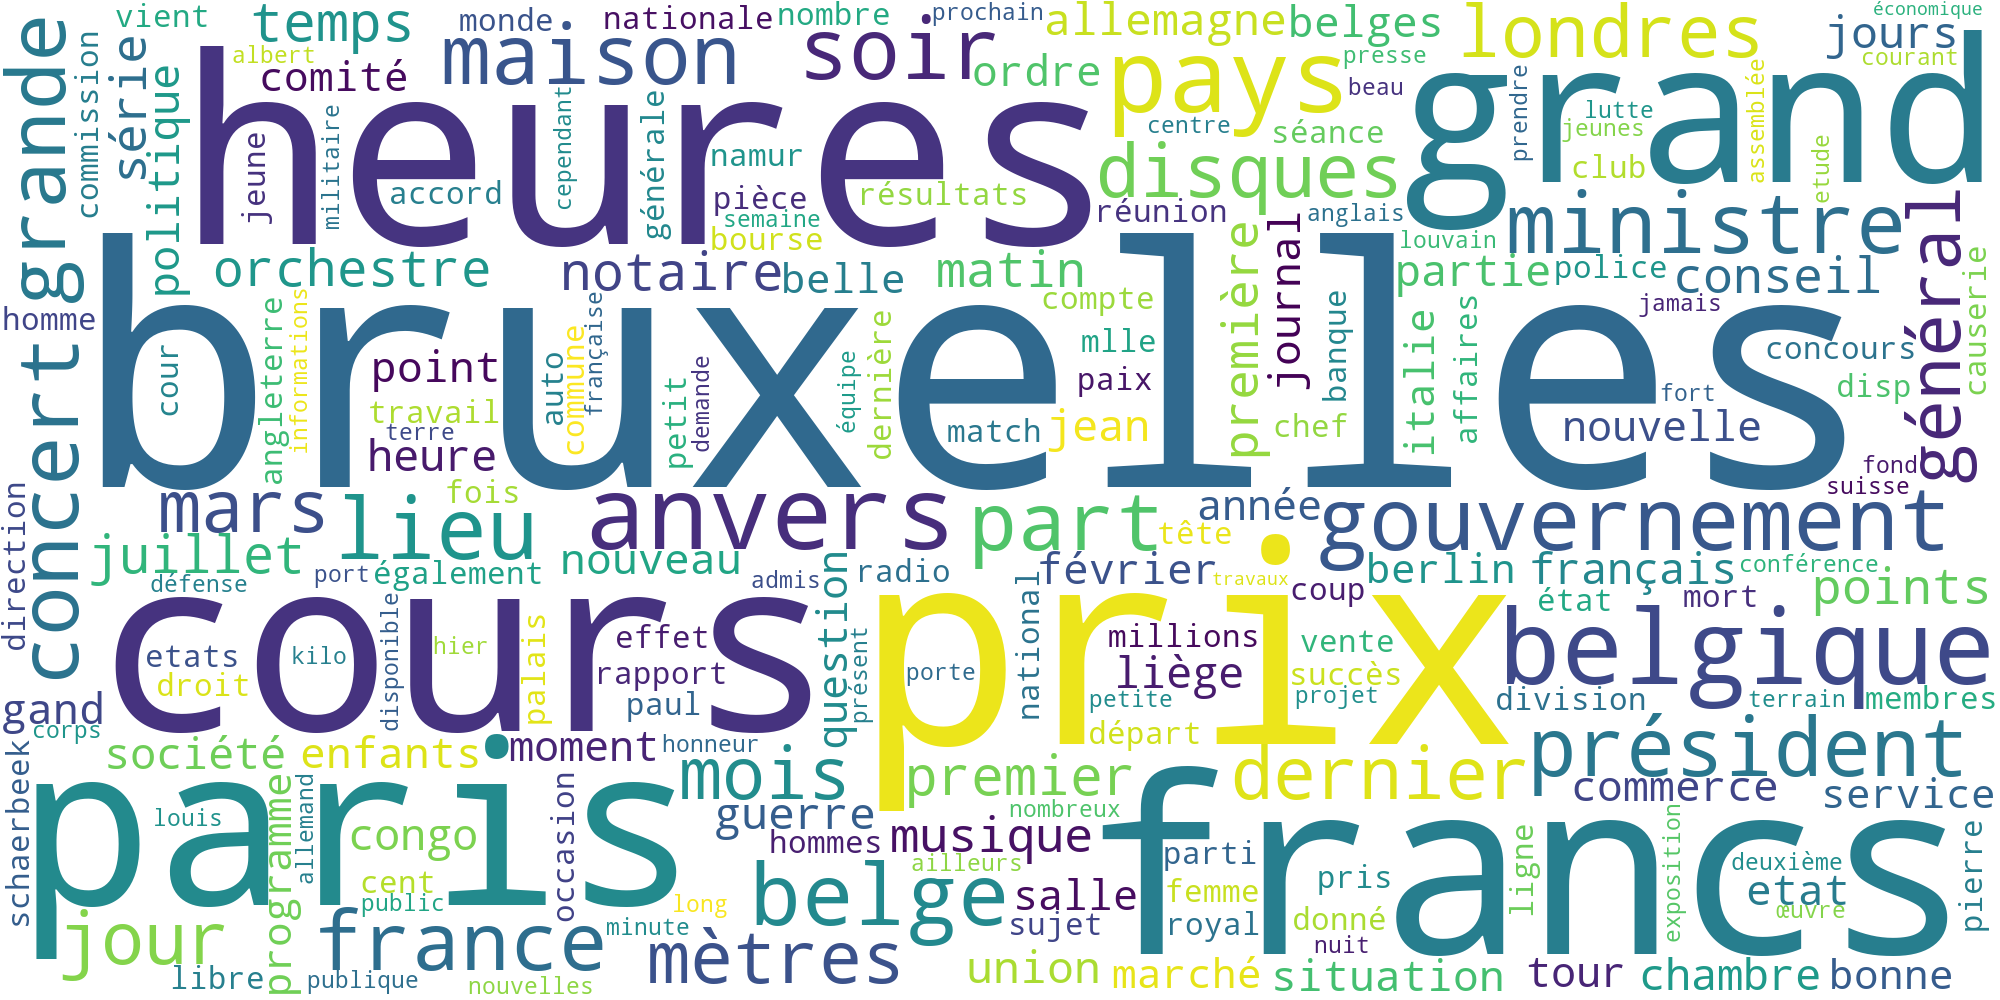

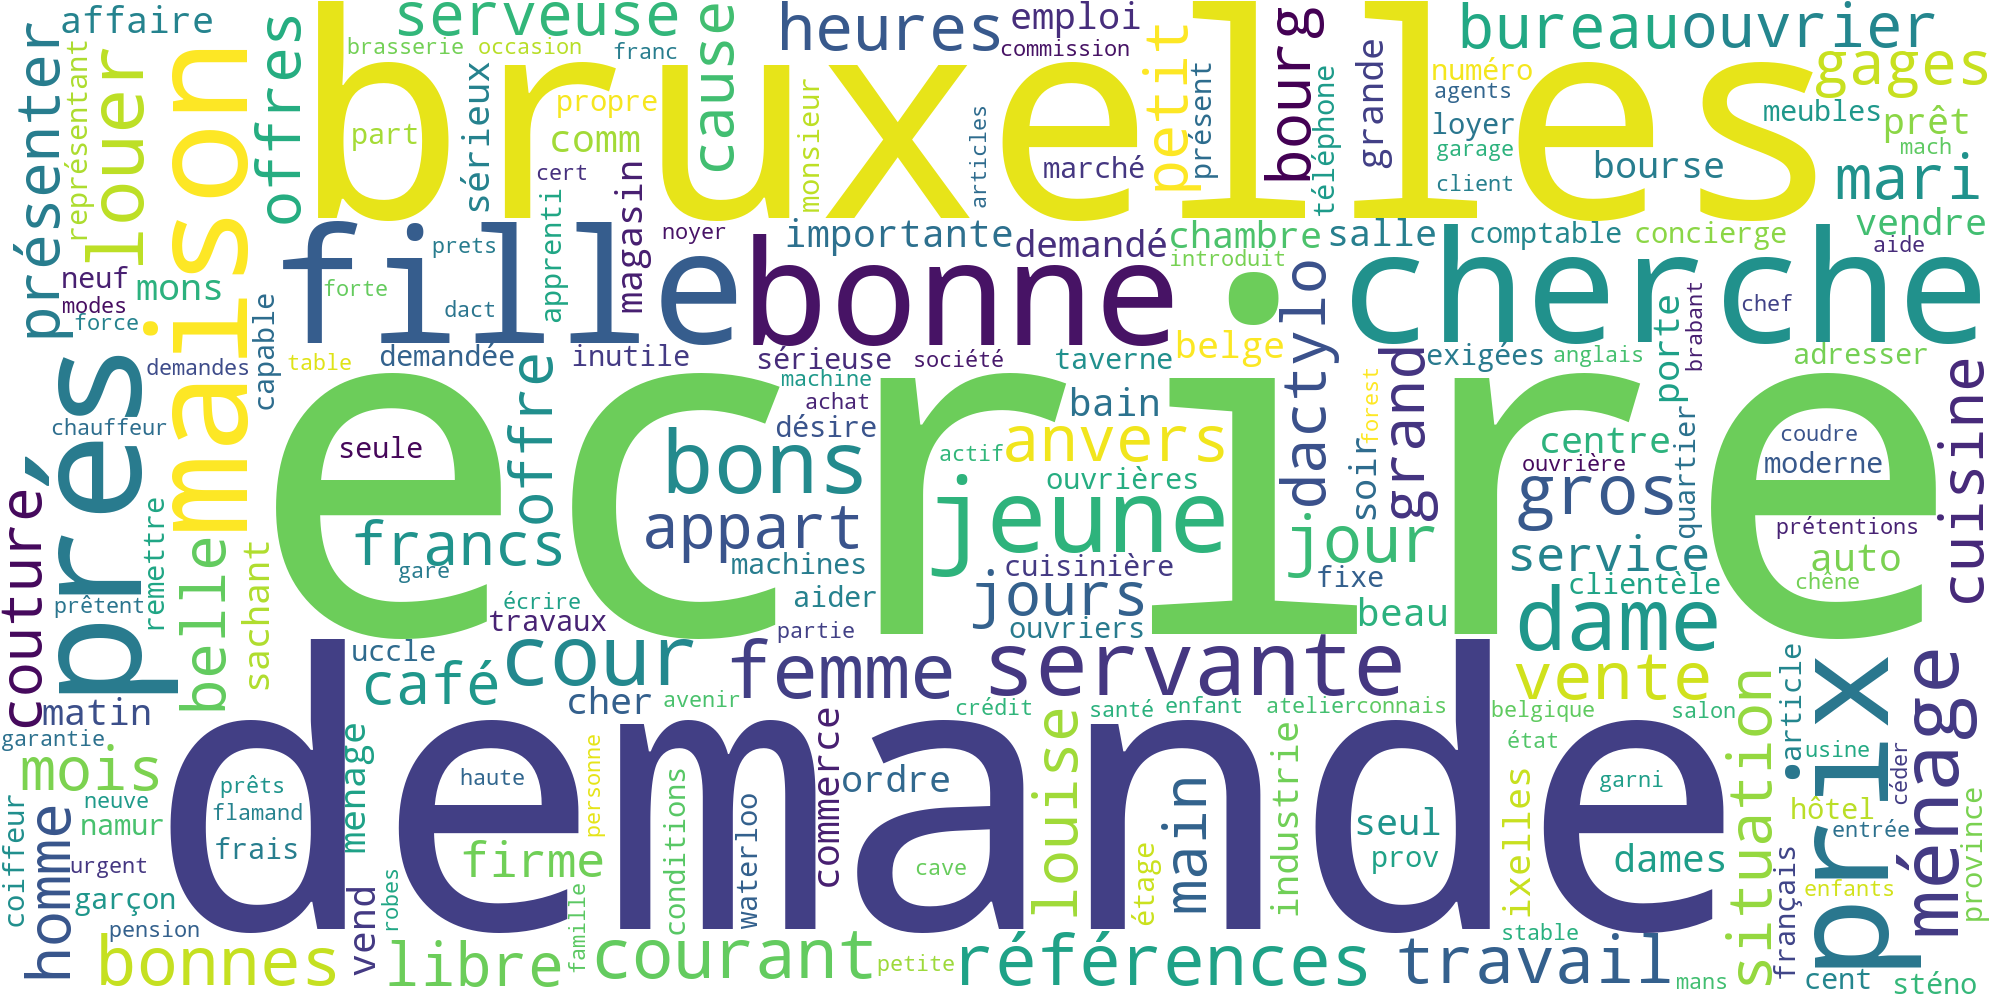

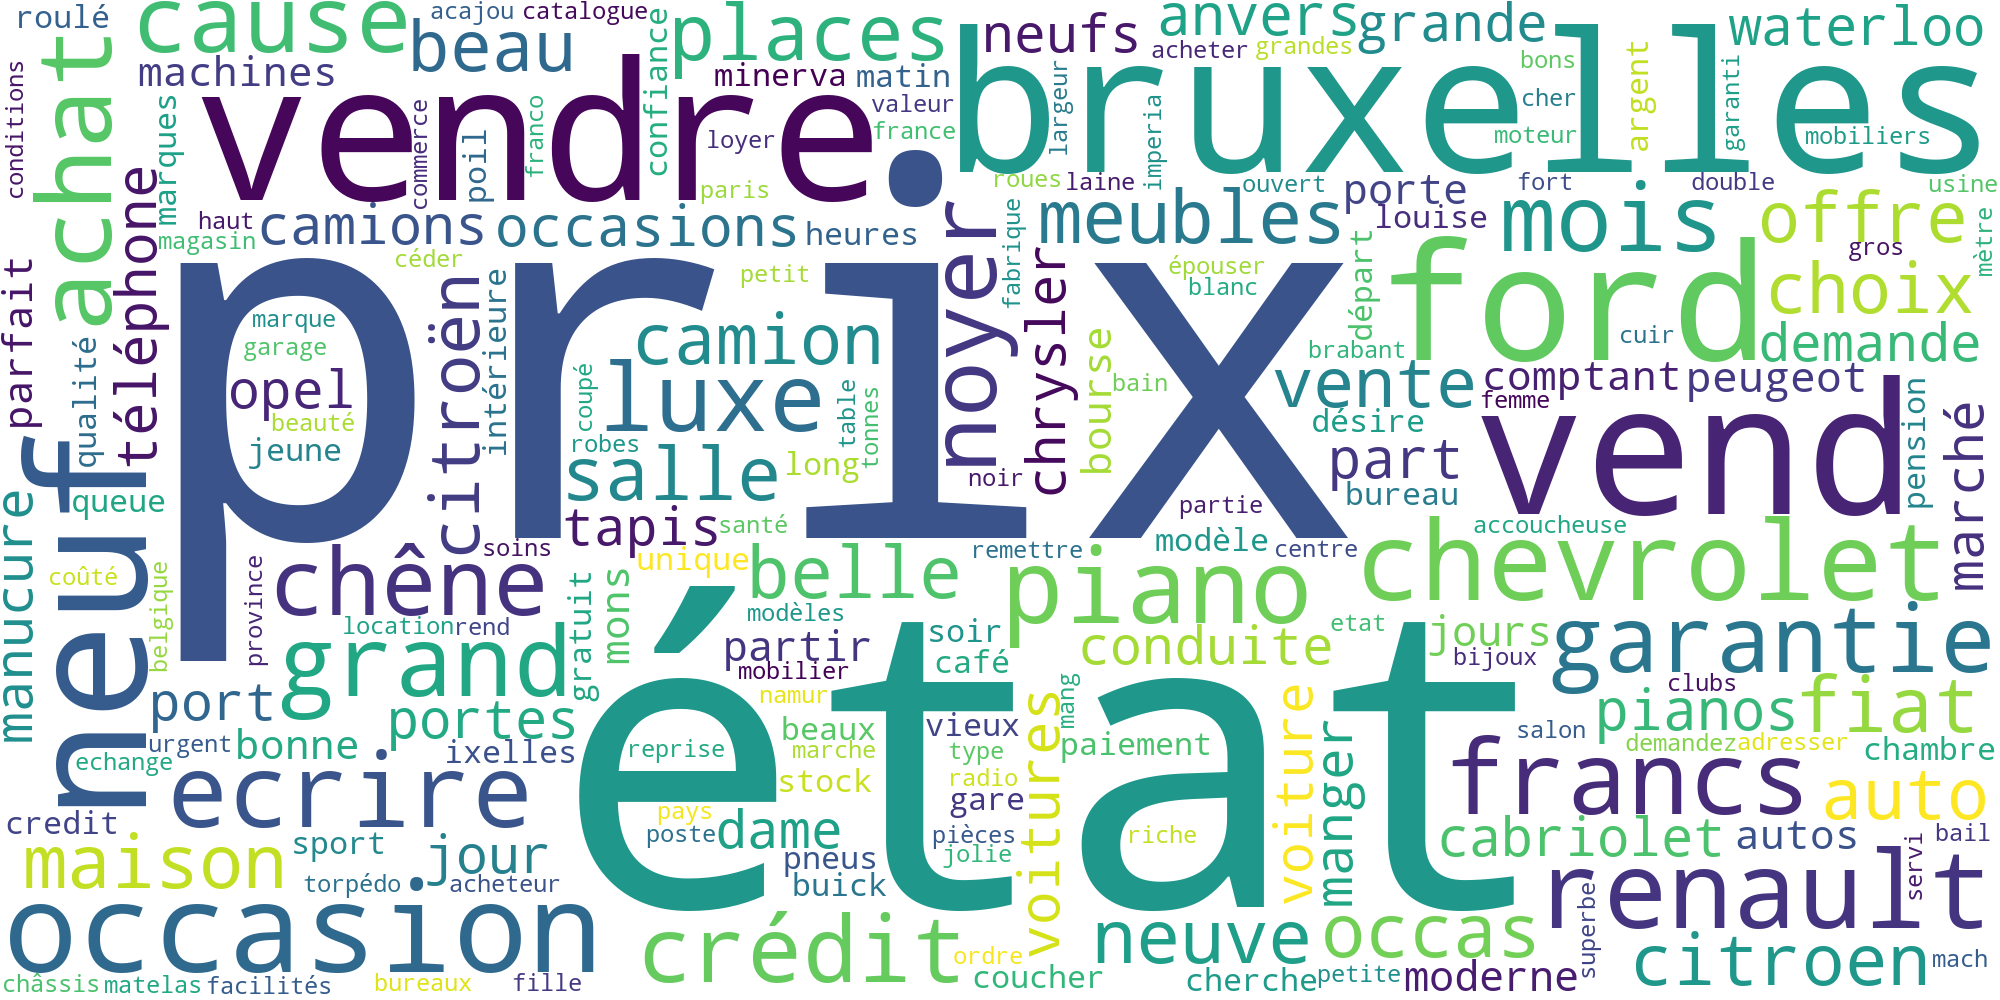

In [26]:
# Solution ad hoc car il semble impossible d'intégrer facilement plusieurs images dans une même cellule d'un jupyer notebook

w = Image(filename=f'{temp_path}1930s_cluster_0.png')
x = Image(filename=f'{temp_path}1930s_cluster_1.png') 
y = Image(filename=f'{temp_path}1930s_cluster_2.png') 
z = Image(filename=f'{temp_path}1930s_cluster_3.png')
display(w, x, y, z)